# Problem 0: Other activation functions (20%)

### The leaky Relu is defined as $max(0.1x, x)$.
 - What is its derivative? (Please express in "easy" format")
 - Is it suitable for back propagation?

### $tanh$ is defined as $\frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}$
 - What is its derivative? (Please express in "easy" format")
 - Is it suitable for back propagation?
 - How is it different from the sigmoid activation
 - What is an example of when to use it? When should you not use it?
 
Please put answers as text below

The derivative of leaky Relu is 1 when x > 0, 0.1 when x < 0; leaky Relu is not differentiable when x = 0. It is suitable for back propagation as it is non-linear activation function with derivative and it provides solutions when x < 0

The derivative of tanh is (1-tanh^2). It is suitable for back propagation because it is non-linear activation function with derivatives. Different from sigmoid activation, tanh is zero centered, making it easier to model inputs that have strongly negative, neutral, and strongly positive values. We use tanh whenever we want to solve the boolean/classification problem (e.g. True or False, Right or Wrong); we should not use it when the x value is very positive large or negative large, where the vanishing gradiant result in almost no change to the prediction, or being too slow to reach an accurate prediction.

# Problem 1: The Deep Learning Recipe (50%)

In this problem, we'll follow the "deep learning recipe" covered in class on the IMDB data.

In [11]:
import numpy as np
import pandas as pd
import glob
import os
%pylab inline
np.random.seed(1234)

Populating the interactive namespace from numpy and matplotlib


## Step 0: load the data

In [32]:
import sys
sys.path.insert(0, ".")
#from helpers import load_imdb_data_text
# or copy the loading function from the notes

In [33]:
def load_imdb_data_text(imdb_data_dir, random_seed=1234):
    train_dir = os.path.join(imdb_data_dir, 'train')
    test_dir = os.path.join(imdb_data_dir, 'test')

    np.random.seed(random_seed)
    texts = []
    targets = []
    for label in ('pos', 'neg'):
        data_dir = os.path.join(train_dir, label)
        files = glob.glob(os.path.join(data_dir, '*.txt'))
        for filename in files:
            with open(filename, encoding='utf8') as fi:
                text = fi.read()
            target = (label == 'pos')
            texts.append(text)
            targets.append(target)

    train_docs = texts
    y_train = np.array(targets)


    texts = []
    targets = []
    for label in ('pos', 'neg'):
        data_dir = os.path.join(test_dir, label)
        files = glob.glob(os.path.join(data_dir, '*.txt'))
        for filename in files:
            with open(filename, encoding='utf8') as fi:
                text = fi.read()
            target = (label == 'pos')
            texts.append(text)
            targets.append(target)

    test_docs = texts
    y_test = np.array(targets)

    inds = np.arange(y_train.shape[0])
    np.random.shuffle(inds)

    train_docs = [train_docs[i] for i in inds]
    y_train = y_train[inds]
    
    return (train_docs, y_train), (test_docs, y_test)

(train_docs, y_train), (test_docs, y_test) = load_imdb_data_text('C:\\Users\\huang\\OneDrive - Massachusetts Institute of Technology\\MIT\\Fall\\15.S08 NLP in Finance\\aclImdb')
print('found {} train docs and {} test docs'.format(len(train_docs), len(test_docs)))

found 25000 train docs and 25000 test docs


Steps 
 - be one with data
 - set up e2e harness + get dumb baselines
 - overfit
 - regualarize
 - tune
 - squeeze

### Step 1: be one with the data
 - make some histograms
 - calculate some summary statistics
 - read a bunch of training examples and discuss any oddities you find
 - finally, turn the data into count vectors

In [34]:
# your code here
# make some plots, calculate some summary stats
import re
def get_tokens(text):
    token_pattern = r"\b\w\w+\\?'?s?(?:-\w+)?\b"
    return re.findall(token_pattern, text.lower())

from collections import Counter
unigram_counts = Counter()
for doc in train_docs:
    # your code here
    tokens = get_tokens(doc)
    for word in tokens:
        unigram_counts[word] += 1
vocab = {token: n for n, token in enumerate(pd.Series(unigram_counts).sort_values().index)}
inv_vocab = {v: k for k, v in vocab.items()}
print('vocabulary size: {}'.format(len(unigram_counts)))
unigram_counts.most_common(10)

vocabulary size: 97122


[('the', 336118),
 ('and', 163814),
 ('of', 145458),
 ('to', 135237),
 ('is', 107306),
 ('br', 101871),
 ('in', 93378),
 ('it', 79088),
 ('this', 75974),
 ('that', 69795)]

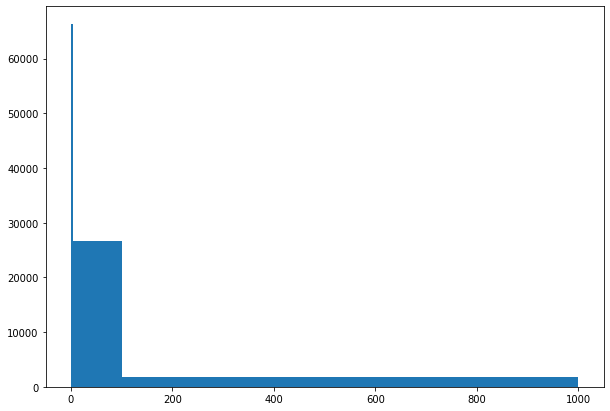

In [35]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize =(10, 7)) 
ax.hist(unigram_counts.values(),bins=[0,5,100,200,1000]) 
plt.show()

In [36]:
# your code here
# print out some documents, find some anomalies
print(train_docs[2])
print()
print(test_docs[2])
# sometimes it's hard to understand the tone of the text due to 
# a number of transition words including but, although, however
# also, take "The ending, as in "Miracle," is not some Disney creation, but one that only human history could have written."
# as an example, there is no strong adjective involved, so it's hard to identify the tone



Michael Winner is probably best known for his revenge-themed films, such as "Death Wish" and "Chato's Land", but he is equally gifted as a director of occult Horror cinema, as "The Sentinel" of 1977 proves. "The Sentinel", which is based on a novel by John Konvitz, who also wrote the screenplay, is a clever and immensely creepy religious chiller that no lover of occult Horror should consider missing. The film is obviously inspired by successful occult classics such as "Rosemary's Baby", "The Exorcist" or "The Omen", but, as far as I am concerned, it is also easily as unsettling as these more widely acclaimed films, and probably even creepier.<br /><br />Allison Parker (Christina Raines) is a beautiful young New York model. Traumatized by events in her her past and not yet willing to marry her lawyer boyfriend (Chris Sarandon), Allison is in search for an apartment, and finds a big, incredibly nice one, which is also affordable, in an old mansion in Brooklyn. The new apartment, however,

In [37]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(max_features=50000, lowercase=True)
vec.fit(train_docs)
x_train = vec.transform(train_docs)
x_test = vec.transform(test_docs)
# vec.fit(...
# x_train = ...
# x_test = ...

## Step 2: set up test harness and get baselines
 - state your baseline models and calculate the log loss and accuracy
   - what is the best constant guess?
   - what about a rules-based model? (e.g. checking if one of a few known words is present)
 - make a function that calculates model performance on the test set
   - `def eval_model(your_model):`
 - make a keras model
   - try to initialize the last layer appropriately (see [here](https://keras.io/api/layers/initializers/))
     - `bias_initializer=Constant(some_constant)`
   - evaluate the model with your function BEFORE training
 - examine data exactly as it is presented to the network
 - make sure you can memorize a batch

In [38]:
# your code here
# calculate the accuracy and log loss for a constant guess
# calculate the accuracy and log loss for a rules based approach

from sklearn.metrics import log_loss, accuracy_score
# our constant guess is 0; our rules-based approach is logisticregression

from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver = 'liblinear')
model.fit(x_train,y_train)

preds_train = (model.predict_proba(x_train)[:,1] >= 0.5).astype(bool)

preds_train2 = np.zeros(len(preds_train))


print('#'*10 + ' logistic regression in sample ' + '#'*10 )
print('\t\taccuracy: {:.3f}'.format(accuracy_score(y_train, preds_train)))
print('\t\tlog_loss: {:.3f}'.format(log_loss(y_train, preds_train)))
print('\n\n')

print('#'*10 + ' constant guess in sample ' + '#'*10 )
print('\t\taccuracy: {:.3f}'.format(accuracy_score(y_train, preds_train2)))
print('\t\tlog_loss: {:.3f}'.format(log_loss(y_train, preds_train2)))
print('\n\n')


########## logistic regression in sample ##########
		accuracy: 0.998
		log_loss: 0.064



########## constant guess in sample ##########
		accuracy: 0.500
		log_loss: 17.269





In [40]:
def eval_model(m):
    # your code here
    preds = m.predict(x_train)
    preds_train = []
    for i in range(len(preds)):
        if preds[i][0] >= 0.5:
            preds_train.append(True)
        else:
            preds_train.append(False)
    print('accuracy: {:.3f}'.format(accuracy_score(y_train, preds_train)))
    print('log_loss: {:.3f}'.format(log_loss(y_train, preds_train)))
    # print or return the accuracy and log loss on the test data

In [41]:
# some other keras imports
import keras.backend as K
from keras.layers import Dense, Dropout, Flatten, Input
from keras.models import Model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.initializers import Constant # for last layer initialization

hint: what value of X do I need for $\sigma(x)$ to be 0.5

In [42]:
# make a model
# inpt = Input(shape=...)
# hidden = ... (inpt)
# hidden = ...(hidden)
# ...
# model = ...
# model.compile... # don't forget to compile it
K.clear_session()
inpt = Input(shape=(50000,))
hidden_state = Dense(32,activation='relu')(inpt)
hidden_state = Dense(32,activation='relu')(hidden_state)
output = Dense(1,activation='sigmoid', bias_initializer = Constant(0))(hidden_state)
model = Model(inpt,output)
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

In [44]:
# evaluate the model before training it
eval_model(model)

accuracy: 0.538
log_loss: 15.961


In [45]:
# examine data as it is presented to the network
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1600032   
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,601,121
Trainable params: 1,601,121
Non-trainable params: 0
_________________________________________________________________


In [46]:
# your code here
# print out a few training examples
# they should be vectors of counts.
# turn them back into words
vocab

{'meningitis': 0,
 'starnberg': 1,
 'completer': 2,
 'jeckyll': 3,
 "flashman's": 4,
 'macdowel': 5,
 'viagra': 6,
 'regime-critical': 7,
 'kinki': 8,
 "step's": 9,
 'viciado': 10,
 'jelaousy': 11,
 'pre-expansion': 12,
 'playbook': 13,
 '10minutes': 14,
 '2hour': 15,
 'reamke': 16,
 'sceanrio': 17,
 'miller-movie': 18,
 'modern-life': 19,
 'wererabbit': 20,
 'astroboy': 21,
 'legioners': 22,
 'love-heat': 23,
 'realty': 24,
 'matthu': 25,
 'routine-orientated': 26,
 'halts': 27,
 "gamera's": 28,
 'direfully': 29,
 'imbecility': 30,
 'gehrlich': 31,
 'ant-semitism': 32,
 'godzilla-imitators': 33,
 'criticzed': 34,
 'hairbrained': 35,
 'conspicous': 36,
 'dubiety': 37,
 'goering': 38,
 'himmler': 39,
 "pig's": 40,
 're-image': 41,
 'over-hype': 42,
 'sulfuric': 43,
 'suxor': 44,
 'damir': 45,
 'tehzeeb': 46,
 'joh': 47,
 'gia': 48,
 'shiven': 49,
 'vinay': 50,
 'khamini': 51,
 'awkrawrd': 52,
 'betwixt': 53,
 'stephani': 54,
 'multilingual': 55,
 'basball': 56,
 '2046': 57,
 'ficker': 5

In [47]:
for i in range(5):
    text = ''
    x = x_train[i].toarray()
    for j in range(50000):
        if x[0][j] > 0:
            text += (inv_vocab[j]) + ' '
    print(text)
    print()

modern-life destructo lindberg's dream-cast super-hearing puttered armed-to sider oversimplification frankenscience wwwf hadha pinkus double-vision horrorpops practical-yet majin jur pimple-faced eres balad 12's hesitantly bakke périnal zigfield caputured pipe's home-loving surror bridesmaid dikkat over-bright community's 28-year anti-celeste strivings antecedently tidwell espoir sylvie's resided somethinbg mussalmaan mst3 ecstacy vadim's schmoozed still-attractive abstains lethargically treasure-hunters shandara bukvic well-appointed miscasted apostoles parenthesis coffee-coasters overfilling exurbia half-documentary chest-puffing mongkut brujas dimeco overly-protective sportsmen failproof lennie non-dubbed dalmar's satana silos vo12no18 classy-yet bernice's neo-nazism holo-brothel ghost-boy neighborrhood bonhomie arch-rival deodorant counterfiet co-signed gowky diamiter rosenfield mcarthur's abigil italian-made prescience alessio backstreets invariable meaney's appalachians dulllllll

In [48]:
# make sure you can "memorize" or complete fit a small batch of data
# try the first 100 training examples
# the loss should go to near 0 pretty quickly
#model.fit(...)
model.fit(x_train[:100],y_train[:100],epochs=10,shuffle=True,batch_size=10)

Epoch 1/10
100/100 [==============================] - 1s 5ms/step - loss: 0.6871 - accuracy: 0.5900
Epoch 2/10
100/100 [==============================] - 0s 3ms/step - loss: 0.4770 - accuracy: 0.7400
Epoch 3/10
100/100 [==============================] - 0s 4ms/step - loss: 0.3231 - accuracy: 0.9700
Epoch 4/10
100/100 [==============================] - 0s 4ms/step - loss: 0.1981 - accuracy: 0.9900
Epoch 5/10
100/100 [==============================] - 0s 3ms/step - loss: 0.1050 - accuracy: 1.0000
Epoch 6/10
100/100 [==============================] - 0s 4ms/step - loss: 0.0539 - accuracy: 1.0000
Epoch 7/10
100/100 [==============================] - 0s 4ms/step - loss: 0.0301 - accuracy: 1.0000
Epoch 8/10
100/100 [==============================] - 0s 4ms/step - loss: 0.0174 - accuracy: 1.0000
Epoch 9/10
100/100 [==============================] - 0s 4ms/step - loss: 0.0117 - accuracy: 1.0000
Epoch 10/10
100/100 [==============================] - 0s 4ms/step - loss: 0.0083 - accuracy: 1.0000

In [49]:
eval_model(model)
# at this point, the model is probably over fit

accuracy: 0.652
log_loss: 12.032


## Part 3:  Overfit
 - make the network large, and convince yourself you can overfit the data

In [50]:
# your code here
K.clear_session()
inpt = Input(shape=(50000,))
hidden_state = Dense(2000, activation="relu")(inpt)
hidden_state = Dense(100, activation="relu")(hidden_state)
output = Dense(1, activation="sigmoid", bias_initializer=Constant(0))(hidden_state)
model = Model(inpt, output)
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['acc'])

In [51]:
# fit the model
#model.fit(...)
model.fit(x_train[:1000],y_train[:1000],epochs=10,shuffle=True,batch_size=1000)

Epoch 1/10
1000/1000 [==============================] - 12s 12ms/step - loss: 0.6986 - acc: 0.4690
Epoch 2/10
1000/1000 [==============================] - 15s 15ms/step - loss: 0.5417 - acc: 0.6870
Epoch 3/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.7206 - acc: 0.5510
Epoch 4/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.2742 - acc: 0.9730
Epoch 5/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.2820 - acc: 0.8820
Epoch 6/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1703 - acc: 0.9550
Epoch 7/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0979 - acc: 0.9950
Epoch 8/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0819 - acc: 0.9960
Epoch 9/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0493 - acc: 0.9990
Epoch 10/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0262 - acc: 0.9990


## Part 4: Regularize
 - use regularizers, dropout, network size, etc

In [52]:
from keras.regularizers import l2,l1,l1_l2
from keras.layers import Dropout

In [53]:
# model code here
# just like you did in the previous part
# add dropout, regularization, maybe remove a Dense layer
# your code here
K.clear_session()
inpt = Input(shape=(50000,))
hidden_state = Dense(2000, activation="relu")(inpt)
hidden_state = Dropout(0.5)(hidden_state)
output = Dense(1, activation="sigmoid", bias_initializer=Constant(0))(hidden_state)
model = Model(inpt, output)
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['acc'])

In [ ]:
# fit the model

In [54]:
model.fit(x_train[:1000],y_train[:1000],epochs=10,shuffle=True,batch_size=1000)

Epoch 1/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7034 - acc: 0.4970
Epoch 2/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.4204 - acc: 0.8930
Epoch 3/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6101 - acc: 0.6740
Epoch 4/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.2010 - acc: 0.9760
Epoch 5/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.3356 - acc: 0.8560
Epoch 6/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1650 - acc: 0.9790
Epoch 7/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0963 - acc: 0.9960
Epoch 8/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0836 - acc: 0.9940
Epoch 9/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0844 - acc: 0.9890
Epoch 10/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0763 - acc: 0.9900


## Part 5 - 6: Tune and Squeeze
It will take a long time to tune the number of units in the Dense layers, so we will skip the tune phase. 

### Todo
 - Retrain the model
 - Make sure let it train enough
 - use callbacks to make sure the network stops before overfitting too much 
 - use callbacks to reduce the learning rate appropriately. 

In [55]:
# model code here
K.clear_session()
inpt = Input(shape=(50000,))
hidden_state = Dense(1000, activation="relu", kernel_regularizer=l2(0.01))(inpt)
hidden_state = Dense(200, activation="relu", kernel_regularizer=l2(0.01))(hidden_state)
hidden_state = Dropout(0.5)(hidden_state)
output = Dense(1, activation="sigmoid", bias_initializer=Constant(0), kernel_regularizer=l2(0.01))(hidden_state)
model = Model(inpt, output)
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['acc'])

In [56]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
# add these callbacks just like we did in class
lr = ReduceLROnPlateau(patience=1, verbose=True)
es = EarlyStopping(patience=2, verbose=True)

In [57]:
# fit the model
model.fit(x_train[:1000],y_train[:1000],epochs=10,shuffle=True,batch_size=1000,callbacks=[lr, es])

Epoch 1/10
1000/1000 [==============================] - 4s 4ms/step - loss: 23.6678 - acc: 0.5160
Epoch 2/10


C:\Users\huang\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
C:\Users\huang\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1000/1000 [==============================] - 3s 3ms/step - loss: 18.8276 - acc: 0.5120
Epoch 3/10
1000/1000 [==============================] - 3s 3ms/step - loss: 14.7491 - acc: 0.6000
Epoch 4/10
1000/1000 [==============================] - 3s 3ms/step - loss: 11.4564 - acc: 0.7020
Epoch 5/10
1000/1000 [==============================] - 3s 3ms/step - loss: 8.8838 - acc: 0.8680
Epoch 6/10
1000/1000 [==============================] - 3s 3ms/step - loss: 6.9338 - acc: 0.8850
Epoch 7/10
1000/1000 [==============================] - 3s 3ms/step - loss: 5.5220 - acc: 0.8830
Epoch 8/10
1000/1000 [==============================] - 3s 3ms/step - loss: 4.5508 - acc: 0.9100
Epoch 9/10
1000/1000 [==============================] - 3s 3ms/step - loss: 3.9258 - acc: 0.9470
Epoch 10/10
1000/1000 [==============================] - 3s 3ms/step - loss: 3.5668 - acc: 0.9560


In [58]:
eval_model(model)
# you should be able to get > 88% accuracy

accuracy: 0.806
log_loss: 6.706


# Problem 2: Transfer Learning (30 %)
In this problem we will explore a technique called transfer learning. Often, we don't have very much labeled data for the problem at hand (we call it __data-poor__), but we can find labeled data for a similar problem (which we call ___data-rich__). 

In transfer learning, we use the __data-rich problem__ to train an network with good performance. We then make a similar network for the __data-poor problem__ but use the weights learned from the first problem in this network. This greatly reduces the amount of data needed to train the data-poor problem. You can think of this as reducing the number of free parameters. 

Here, we will use the mnist digit recognition problem. We will pretend that we are interested in telling the difference between the digits `4` and `9`, but we only have 10 labeled examples. We will pretend that we have tons of labeled examples of all of the other digits. 

In [4]:
import numpy as np
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
# add some imports
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.datasets import mnist
import keras.backend as K
from sklearn.metrics import accuracy_score, f1_score
np.random.seed(1234)

# $ \\ $

## Part 0: Subset the data into two datasets
 1. One part will have `x_train_49`, `y_train_49`, etc. which has only `4`s and `9`s. 
 2. The second part will have variables `x_train_rest` etc, which will have the rest of the data and none of the digits `4` and `9`. 

In [7]:
from keras.utils import to_categorical

def preprocess_training_data(data):
    data = data.reshape(data.shape[0], data.shape[1] * data.shape[2])
    data = data.astype('float32') / 255
    return data

def preprocess_targets(target, num_classes):
    return to_categorical(target, num_classes)


def subset_to_9_and_4(x, y):  # this is a new function
    mask = (y == 9) | (y == 4)
    new_x = x[mask]
    new_y = (y[mask] == 4).astype('int64')
    return new_x, new_y

def subset_to_rest(x, y):  # this is a new function
    mask = ~((y == 9) | (y == 4))
    new_x = x[mask]
    new_y = y[mask]
    return new_x, new_y


(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = preprocess_training_data(x_train)
x_test = preprocess_training_data(x_test)

num_classes = np.unique(y_train).shape[0]

y_train_ohe = preprocess_targets(y_train, num_classes)
y_test_ohe = preprocess_targets(y_test, num_classes)

train_frac = 0.8
cutoff = int(x_train.shape[0] * train_frac)
x_train, x_val = x_train[:cutoff], x_train[cutoff:]
y_train, y_val = y_train[:cutoff], y_train[cutoff:]
y_train_ohe, y_val_ohe = y_train_ohe[:cutoff], y_train_ohe[cutoff:]

x_train_49, y_train_49 = subset_to_9_and_4(x_train, y_train)
x_val_49, y_val_49 = subset_to_9_and_4(x_val, y_val)
x_test_49, y_test_49 = subset_to_9_and_4(x_test, y_test)

print(x_train_49.shape)

x_train_rest, y_train_rest = subset_to_rest(x_train, y_train)
x_test_rest, y_test_rest = subset_to_rest(x_test, y_test)

y_train_rest_ohe = to_categorical(y_train_rest, num_classes)
y_test_rest_ohe = to_categorical(y_test_rest, num_classes)



(9457, 784)


# $ \\ $
## Now we will throw away most of the training data for the 4-9 problem
 - we will keep only 10 points

In [14]:
num_points = 10
x_train_49, y_train_49 = x_train_49[:num_points], y_train_49[:num_points]

# $ \\ $

## Part 1: Build a neural network to fit the `rest` data.
 - ### Include 2 densely connected hidden layers with 256 neurons each.
 - The output dimension should be either 8 or 10, depending on how you do the problem
 - ### Compute the accuracy score for this model

# $ \\ $

In [15]:
K.clear_session()
num_hidden_units = 256

In [16]:
digit_input = Input(shape=(x_train_rest.shape[1],), name='digit_input')
# add code here
hidden1 = Dense(num_hidden_units, activation="relu")(digit_input)
hidden2 = Dense(num_hidden_units, activation="relu")(hidden1)
output = Dense(num_classes, activation="softmax")(hidden2)
model_rest = Model(digit_input, output)
model_rest.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

### Fit the model for 10 epochs and compute the accuracy score

In [17]:
model_rest.fit(x_train_rest, y_train_rest_ohe, 
    batch_size=512,
    epochs=10, 
    shuffle=True)

Epoch 1/10
38543/38543 [==============================] - 1s 36us/step - loss: 0.4535 - accuracy: 0.8772
Epoch 2/10
38543/38543 [==============================] - 1s 29us/step - loss: 0.1487 - accuracy: 0.9567
Epoch 3/10
38543/38543 [==============================] - 1s 32us/step - loss: 0.1007 - accuracy: 0.9706
Epoch 4/10
38543/38543 [==============================] - 1s 28us/step - loss: 0.0746 - accuracy: 0.9788
Epoch 5/10
38543/38543 [==============================] - 1s 28us/step - loss: 0.0547 - accuracy: 0.9841
Epoch 6/10
38543/38543 [==============================] - 1s 28us/step - loss: 0.0461 - accuracy: 0.9866
Epoch 7/10
38543/38543 [==============================] - 1s 28us/step - loss: 0.0350 - accuracy: 0.9904
Epoch 8/10
38543/38543 [==============================] - 1s 28us/step - loss: 0.0282 - accuracy: 0.9920
Epoch 9/10
38543/38543 [==============================] - 1s 30us/step - loss: 0.0231 - accuracy: 0.9938
Epoch 10/10
38543/38543 [==============================

In [18]:
accuracy_score(y_test_rest, np.argmax(model_rest.predict(x_test_rest), axis=1))

0.9812710700461981

# $ \\ $ 
## Part 2: Fit a model on the `4`-`9` data
 - ### Use the same 2 densely-connected layers with 256 hidden units
 - ### Here the output layer could have 1 or two units, depending on how you set up the problem
 - ### NB: DO NOT use `K.clear_session()` because we need stuff for later. 

In [19]:
digit_input_49 = Input(shape=(x_train_49.shape[1],), name='digit_input')
# add code here
hidden1_49 = Dense(num_hidden_units, activation="relu")(digit_input_49)
hidden2_49 = Dense(num_hidden_units, activation="relu")(hidden1_49)
output_49 = Dense(1, activation="sigmoid")(hidden2_49)
model49 = Model(digit_input_49, output_49)
model49.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [20]:
model49.fit(x_train_49, y_train_49, validation_data=(x_val_49, y_val_49), epochs=1000, shuffle=True)

y_pred_49=model49.predict(x_test_49)
y_pred_49=(y_pred_49>0.5).astype(int)

Train on 10 samples, validate on 2334 samples
Epoch 1/1000
10/10 [==============================] - 0s 27ms/step - loss: 0.6515 - accuracy: 0.8000 - val_loss: 0.6613 - val_accuracy: 0.5668
Epoch 2/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.4752 - accuracy: 1.0000 - val_loss: 0.6437 - val_accuracy: 0.5818
Epoch 3/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.3564 - accuracy: 1.0000 - val_loss: 0.6291 - val_accuracy: 0.6028
Epoch 4/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.2668 - accuracy: 1.0000 - val_loss: 0.6153 - val_accuracy: 0.6221
Epoch 5/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.1959 - accuracy: 1.0000 - val_loss: 0.6031 - val_accuracy: 0.6517
Epoch 6/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.1389 - accuracy: 1.0000 - val_loss: 0.5956 - val_accuracy: 0.6705
Epoch 7/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0963 - accuracy: 1.

In [24]:
print(accuracy_score(y_test_49, y_pred_49))
print(f1_score(y_test_49, y_pred_49))

0.6921145153189352
0.724494382022472


# $ \\ $ 
## Part 3: Transfer Learning:
 - ### Make an identical model to part 2, but take the weights learned from the original model on the rest of the data.
 - ### NB: the `Dense` layer takes a `weights=` keyword argument
 - ### Try making the layers static or trainable.


In [26]:
digit_input_transfer = Input(shape=(x_train_49.shape[1],), name='digit_input')
# add code here
hidden1_transfer = Dense(num_hidden_units, activation="relu", weights=model_rest.layers[1].get_weights())(digit_input_transfer)
hidden2_transfer = Dense(num_hidden_units, activation="relu", weights=model_rest.layers[2].get_weights())(hidden1_transfer)
output_transfer = Dense(1, activation="sigmoid")(hidden2_transfer)
model_transfer = Model(digit_input_transfer, output_transfer)
model_transfer.layers[1].trainable=False
model_transfer.layers[2].trainable=False
model_transfer.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


In [27]:
# model_transfer.fit(...    epochs=100, 
# accuracy_score...
# f1_score...
model_transfer.fit(x_train_49, y_train_49, validation_data=(x_val_49, y_val_49), epochs=100, shuffle=True)

Train on 10 samples, validate on 2334 samples
Epoch 1/100
10/10 [==============================] - 0s 17ms/step - loss: 0.6270 - accuracy: 0.7000 - val_loss: 0.6147 - val_accuracy: 0.6632
Epoch 2/100
10/10 [==============================] - 0s 12ms/step - loss: 0.6000 - accuracy: 0.7000 - val_loss: 0.6098 - val_accuracy: 0.6637
Epoch 3/100
10/10 [==============================] - 0s 10ms/step - loss: 0.5770 - accuracy: 0.8000 - val_loss: 0.6062 - val_accuracy: 0.6645
Epoch 4/100
10/10 [==============================] - 0s 12ms/step - loss: 0.5569 - accuracy: 0.7000 - val_loss: 0.6029 - val_accuracy: 0.6620
Epoch 5/100
10/10 [==============================] - 0s 13ms/step - loss: 0.5389 - accuracy: 0.7000 - val_loss: 0.5994 - val_accuracy: 0.6555
Epoch 6/100
10/10 [==============================] - 0s 13ms/step - loss: 0.5230 - accuracy: 0.7000 - val_loss: 0.5947 - val_accuracy: 0.6585
Epoch 7/100
10/10 [==============================] - 0s 12ms/step - loss: 0.5071 - accuracy: 0.7000 - 

0.8290981564524166

In [28]:
y_pred_transfer=model_transfer.predict(x_test_49)
y_pred_transfer=(y_pred_transfer>0.5).astype(int)
print(accuracy_score(y_test_49, y_pred_transfer))
print(f1_score(y_test_49, y_pred_transfer))

0.8277247614264189
0.8290981564524166


## Part 4: Analysis:
 - We only transferred the first two layers and not the last one. Why?
 - Write the answer in a markdown cell

The last layer should not be transferred because the output dimensions are different for the two neural networks. The last layer in the model to fit rest data has 10 neurons corresponding to the 10 classes, using softmax as the activation function. In the model to predict 4 or 9, the last layer has only 1 neuron, and the activation function is sigmoid. The former model is a multiclass classification problem, whereas the latter is a binary classification problem. Therefore, they should have different last layers.